In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
      
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out

  def __neg__(self): #-self
      return self * -1

  def __sub__(self, other): #self-other; implement thru addition by negation, mult by -1 for the negation (what we've built)
      return self + (-other)
      
  def __pow__(self, other): #self to the pow of other
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,),f'**{other}')

      def _backward(): #what's the chain rule for backprop thru the power function, where power is power of some kind of constant
        self.grad += other * self.data ** (other -1) * out.grad
                    #other * self.data ** (other -1) is the local derivative only, but then have to chain it by mult by out.grad
                            #self.data is an int or a float, not a Value obj, just accessing .data prop
        #to do the above exercises, go to the derivative rules
      out._backward = _backward
      return out

  def __rmul__(self,other): #other * self; fallback for python not being able to do num * self, check if rmul in value, call it reverse
      return self * other

  def __truediv__(self, other): #self/other
      return self*other**-1
      
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

  def exp(self): #mirrors tanh; inputs, transforms, and outputs a single scalar value
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      #how do you backpropogate through e^x We need to know the local deriv of e^x. D/dx of e^x is e^x
      #eturns E raised to the power of x (Ex).
        #'E' is the base of the natural system of logarithms (approximately 2.718282) and x is the number passed to it.
      def _backward():
          self.grad += out.data * out.grad
      out._backward = _backward
      return out
      
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
#a + 1 : python can't access 1.data (1 is other), we only have addition thru value objects, 1 is not a value obj
# adjusted to make num a value obj if not instance of value
#a * 2 a.__mul__(2) != 2.__mul__(a)
b = Value(4.0)
#a/b same as a * 1/b and a * b**-1
#implement n**k and as special case -1 is division

a-b

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2; the synaptec strengths of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b; 
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b; doing it in small steps so we have pointers to the intermediate steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#output -> o; need to write tanh. Implement this tanh function because tanh is a hyperbolic function,
#and we only have so far implemented a plus and a times. Can't make a tanh out of just + and x. 
#Also need exponentiation and division:
o = n.tanh(); o.label = 'o'
o.backward()

In [ ]:
draw_dot(o)

Breaking up tanh into hyperbolic cotangent -> e*2x + 1 / e^2x - 1

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2; the synaptec strengths of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b; 
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b; doing it in small steps so we have pointers to the intermediate steps
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#-----
#Breaking up tanh into hyperbolic cotangent -> e*2x + 1 / e^2x - 1
e = (2*n).exp()
o = (e - 1) / (e + 1)
#backward pass is correct because the grad's from backprop turn out to be same as before (tanh)
#-----
o.label = 'o'
o.backward()
draw_dot(o)

In conclusion all that matters is input and output, output is a func of the inputs in some way. As long as you can do forward and backward pass of the local operation, deosn't matter how composite the function is (simple is atomic). 

If you can write the local gradients, you can chain the gradients, and you can do backpropogation. Design of the functions are up to you. 

Now, use a modern dnn library like pytorch, would typically use in production. Can do the same thing with the API. Micrograd is a scalar valued engine (2.0). Only have scalar values. In pytorch, everything is based around tensors, which are n-dimensional arrays of scalars. Need a scalar valued tensor. 



In [4]:
import torch 

In [5]:
#cast to double so float 32 (default) is cast to float 64
#because these are leaf nodes, pytorch assumes they don't require gradients
#have to explicitly say all nodes require gradients. Going to construct scalar valued, one element tensors
#By default, requires_grad is set to false (efficiency), because you wouldn't usually want gradients for leaf nodes as input to the network
#once we have defined all values, can perform arithmetic
#just like in micrograd, these tensor objects have a .data and a .grad...
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) #takes a single tensor of one elemnts and returns element, stripping out the tensor
#prints forward pass
o.backward()

#prints gradients/backwards pass
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

#torch can do what we did in micrograd, as a special case when your tensors are all single-element tensors. 
#with pytorch, everything else is much more efficient because we're working with tensor objects. Many operaitons in parallel 
#with these tensors. Everything we've built agrees with pytorch.

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o #tensor object, has a backward function just like what we implemented

In [ ]:
o.item()   #

In [ ]:
x1.grad.item() #-> grad is a tensor, pop out number with .item()

In [ ]:
torch.Tensor([3.0]).double().dtype     #defualt is float 32... add in double() to make it float64

Now that we have some machinery to build pretty complicated mathematical expressions, can also start building out neural nets.

Neural nets are a specific class of mathematic expressions. Going to start building out a nn piece by piece, and eventually build out a 
two layer Multi-Layer Perceptron. Let's start with a single individual neuron. We'll design it to subscribe to PyTorch's API and its specific nueral network modules.

Now, we're going to define a layer on neurons... So look up schematic for MLP. MultiLayer Perceptron.
Notice how there are multiple layers with multiple neurons. The neurons are not connected to each other, but are rather connected to all of the inputs. A layer of neurons is a set of neurons evaluated independently. 



In [ ]:
#look up cnn cs231n for visual recognition pic

In [6]:
import random
class Neuron:
    def __init__(self,nin):  #constructor takes num of inputs to the neuron, creates a weight of some random number between -1 and 1,
                            # and a bias that controls trigger happinesss of the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):   #multiply all elements of w with all eles of x (pairs)
        #when you use n(x) notation, python will use __call__()
        #w * x + b -> w*x is a dot product.
        #zip takes two iterators, makes a new iterator that iterates over tuples of corresponding entries (self.w[3], x[3])
        #print(list(zip(self.w,x)))
        #create raw activation function
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)    #by default, builds a sum on top of 0.0, so we start with self.b instead
        #pass through 
        out = act.tanh()
        return out
class Layer: # a list of neurons, take num neurons as argument, and num in out you want in out layer
#one layer for an MLP
    #nin is independent neurons, nout is number of neurons in a singel laayer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs #allows us to get a single value out for last layer with 1 neuron

class MLP:
    def __init__(self, nin, nouts): #take a list of nouts (instead of single nout), which defines size of all layers we want in MLP
        sz = [nin] + nouts #put them all together 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]   #iterate over consecutive pairs of these sizes and create layer objects for them

    #calling them sequentially
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

#x = [2.0, 3.0]
#n = Layer(2, 3)
#n(x) -> two dimensional neurons, 3 of them

#in the picuture, two tensors of 4 + 1 output
x = [2.0, 3.0, -1.0]   #three dimensional input
n = MLP(3, [4, 4, 1])  #three inputs into two layers of four and one output
n(x)   #python uses __call__ when calling n(x

#Now we can forward a single neuron....
#gets a different output each time because init diff weights and biases each time

Value(data=0.8740346417562901)

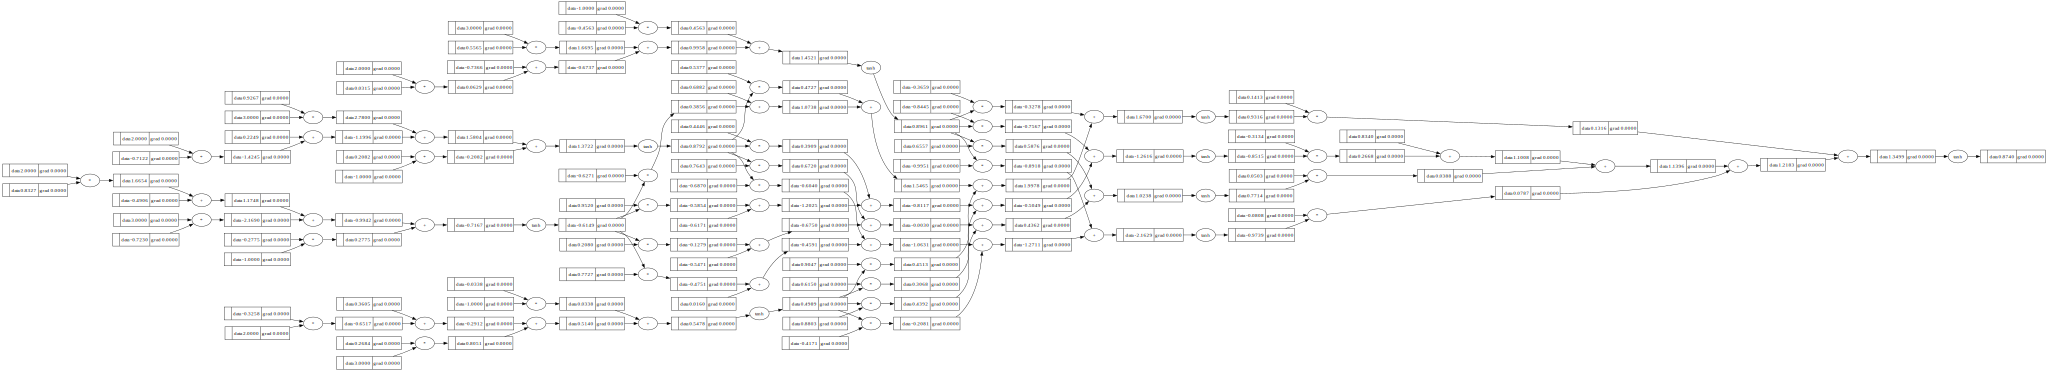

In [7]:
draw_dot(n(x))

In [8]:
#example dataset, four possible inputs/examples into neural net, and four desired targets. 
#would like neural net to ouptut ys[0] when fed first array, ys[1] for second array, etc.
#Very simple binary classifier neural net.
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
#see what the classifier thinks of our examples
ys_value = [Value(y) for y in ys] #convert y's into value objects to compare them
ypred = [n(x) for x in xs]
ypred #outputs of neural net on the four examples -> predictions

[Value(data=0.8740346417562901),
 Value(data=0.5016306379213383),
 Value(data=0.8045707123801448),
 Value(data=0.8268752030021981)]

In [15]:
#how do we train the neural net to output the desired targets? Calc a single number that measures the total performance
#of the neural net. This is called the loss. Want to minimize it. Implement mean squared error loss. 
#means we iterate for y ground truth and y output in the zip of ys, an dypred... pair up the ground truths with the predictions
#zip iterates over tuples of them. For each y ground truth and y output, we subtract them and square them

#mean squared error
#[(yout - ygt) ** 2 for ygt, yout in zip (ys, ypred)]
#final loss:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys_value,ypred)])
#loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss
#compares the output to desired output byt subtracting it and squaring it (avoid negatives). You only get 0 when yout == ygroundtruth
#The loss is the sum of these losses(differences)

#error: restarted kernel because ypred was getting n() as a Value object so ypred was a value object and would not sit with ys
#which is of type float

#now we want to minimize the loss
#loss.backward()

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [17]:
#for each one of the four losses, we are taking the prediciton and ground truth, subtracitng them, and squaring them. 
# if they are close, subtracting gives a small number, and then squaring it makes sure whetehr we are more negative or positive,
# we make sure we always get a positive number. We only get 0 when yout == ygt (y out == y ground truth.
# when those two are equal, prediction is exactly the target, get 0. If not, you get some other number. 
